# Hanny's Voorwerp Particle Model

Working with the image from [here.](https://www.nasa.gov/mission_pages/hubble/science/space-oddity.html)

In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

import hdbscan


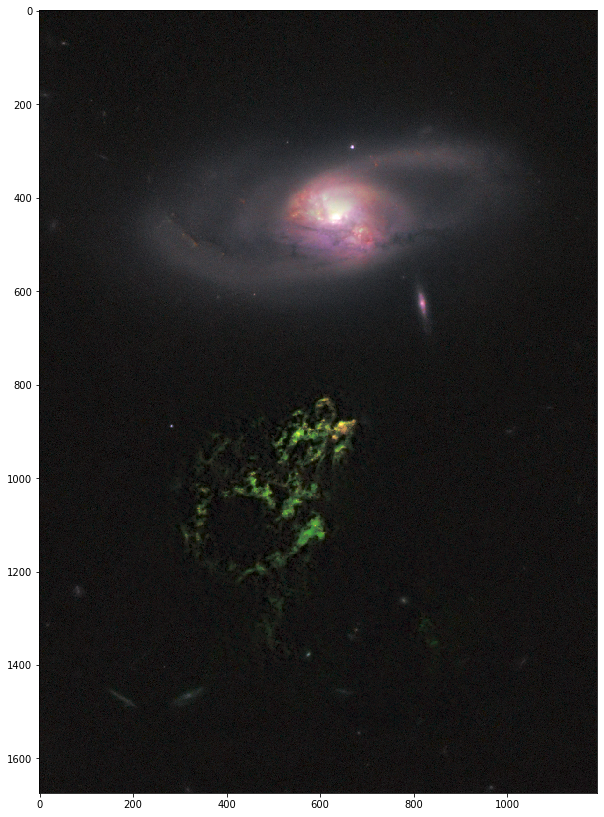

In [2]:
%matplotlib inline

im = Image.open('509256main_p1101a1.tif')
imarray = np.array(im)

f,ax = plt.subplots(1,1, figsize=(10,20))
ax.imshow(imarray)

In [3]:
ny, nx, nz = imarray.shape
print(imarray.shape)

(1674, 1194, 3)


### Separate the colors and calculate the luminance

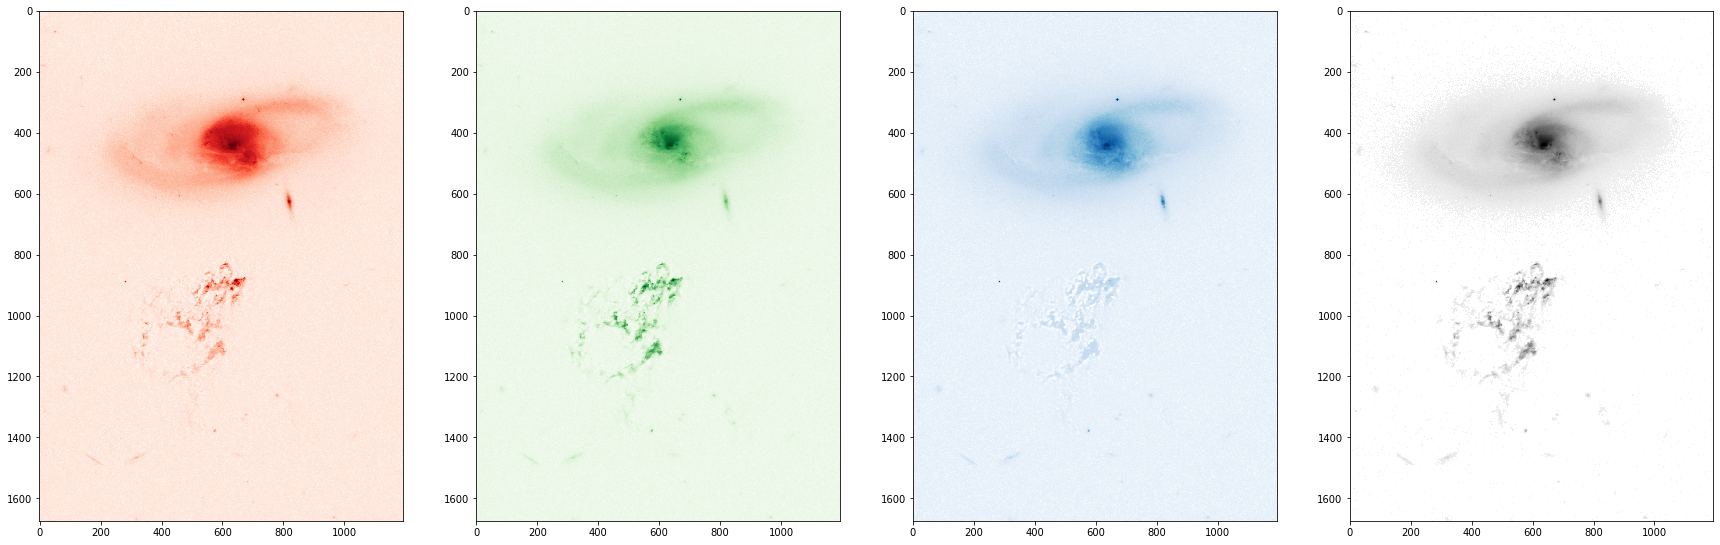

In [4]:
%matplotlib inline

#threshold = 0.2 #from trial and error
threshold = 0.11 #from trial and error

r = imarray[:, :, 0]/255.
g = imarray[:, :, 1]/255.
b = imarray[:, :, 2]/255.
luminance = 0.2126*imarray[:,:,0]/255. + 0.7152*imarray[:,:,1]/255. + 0.0722*imarray[:,:,2]/255.
low = np.where(luminance < threshold)
luminance[low] = 0

f,(ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30, 10))
ax1.imshow(r, cmap='Reds')
ax2.imshow(g, cmap='Greens')
ax3.imshow(b, cmap='Blues')
ax4.imshow(luminance, cmap='Greys')


### Sample from the luminance array to create particles

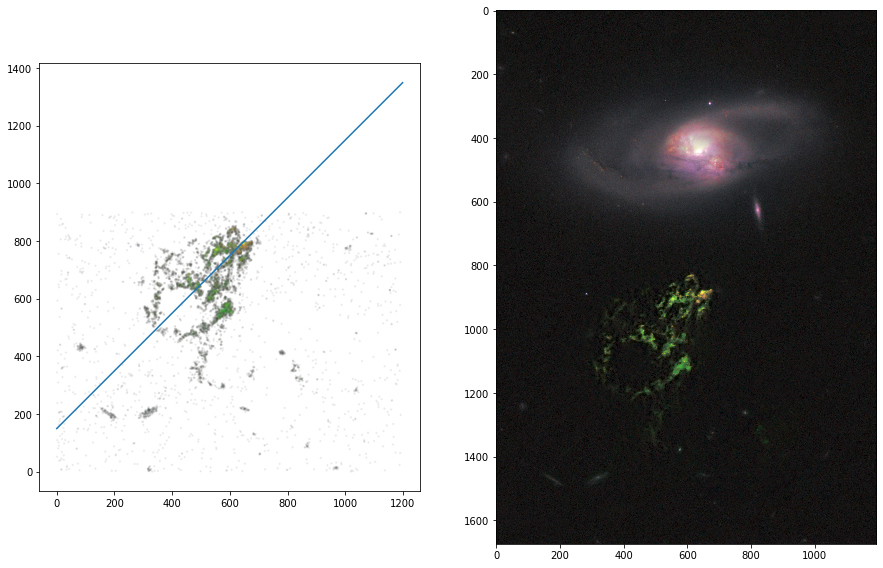

In [5]:
%matplotlib inline

resampleX = []
resampleY = []
resampleZ = []
resampleRGB = []
resampleRGBA = []
norm = 1.#0.1

zfac = 50. #scaling factor fo gaussian distribution of points based on luminance
zmax = 25
cx = 500
cy = 650
zlfac = 150.
for i in range(ny)[775:]:
    row = luminance[i,:]
    sumRow = np.sum(row)
    if (sumRow > 0):
        nn = np.sum(row)/norm
        pp = row/sumRow
        n = int(np.round(nn))
        #print(i, n, row)
        xx = np.random.choice(nx, size=n, p=pp)
        xoff = np.random.random(size=n) #to avoid obvious pixelation
        yoff = np.random.random(size=n) #to avoid obvious pixelation
        resampleX.extend(xx + xoff)
        resampleY.extend(np.ones(n)*(ny - i) + yoff)
        
        #take luminance as the standard deviation of the random normal?
        scale = np.clip(row[xx]**1.5*zfac, 0, zmax)
        
        #choose some function for the central z position
        #pxy = (np.abs(i - cy) + np.abs(np.arange(len(row))[xx] - cx))/(cx + cy) #x + y
        xval = np.arange(len(row))[xx]
        yval = i
        yline = xval + 150
        #pxy = (np.abs(yval - yline) + np.abs(xval - cx))/(cx + cy) #centered on y = x + 150
        #pxy = np.abs(yval - yline)/cy #centered on y = x + 150
        pxy = (xval - cx)**2./(0.4*cx)**2. + (yval - yline)**2./cy**2. #elliptical paraboloid
        loc = zlfac*pxy**2.
        #loc = np.zeros_like(pxy)
        
        #add some wiggles?
        #pxy = (xval - cx)**2./(0.2*cx)**2. + (yval - yline)**2./(0.4*cy)**2. #elliptical paraboloid
        #loc += zlfac*np.sin(pxy)/5.
        
        #add a random offset but to clumps
        #loc += np.random.normal(size=n, scale=zlfac/5., loc=0)
        
        #limit the overall size
        check = np.where(np.abs(loc) > 2.*zlfac)
        loc[check] = np.random.normal(size = len(check), scale=zlfac, loc=0)
        #loc = np.clip(loc, -4.*zlfac, 4.*zlfac)
        
        #print(loc, i, (i - cy), (np.arange(len(row))[xx] - cx))

        resampleZ.extend(np.random.normal(size=n, scale=scale, loc=loc))

        resampleRGB.extend((imarray[i,xx,:]/255.).tolist())
        resampleRGBA.extend( np.array([imarray[i,xx,0]/255., imarray[i,xx,1]/255., imarray[i,xx,2]/255., np.ones(len(xx))]).T.tolist())
        #resampleRGB.extend(tuple(map(tuple, imarray[i,xx,:])))
        
f,(ax1, ax2) = plt.subplots(1,2,figsize=(15,20))
#ax1.plot(resampleX, resampleY,'.', markersize=2, alpha=0.004, color='black')
ax1.scatter(resampleX, resampleY, s=2, alpha=0.05, c=resampleRGB)
ax1.set_aspect('equal')
xval = np.arange(1200)
yval = xval + 150
ax1.plot(xval, yval)
ax1.plot()
ax2.imshow(imarray)#luminance, cmap='Greys')

FigureCanvasNbAgg()

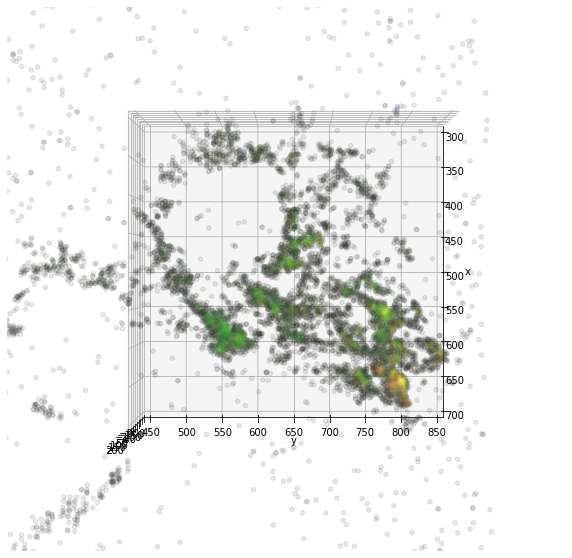

In [7]:
%matplotlib widget

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, projection='3d')
ax.scatter(resampleX, resampleY, resampleZ, c=resampleRGB, s=20, alpha=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(300, 700)
ax.set_ylim(450, 850)
ax.set_zlim(-200,200)
ax.view_init(90,0) #x,y
#ax.view_init(45, 45)

## Try clump finding

*https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#hdbscan*

*https://hdbscan.readthedocs.io/en/latest/*

(12001, 2)


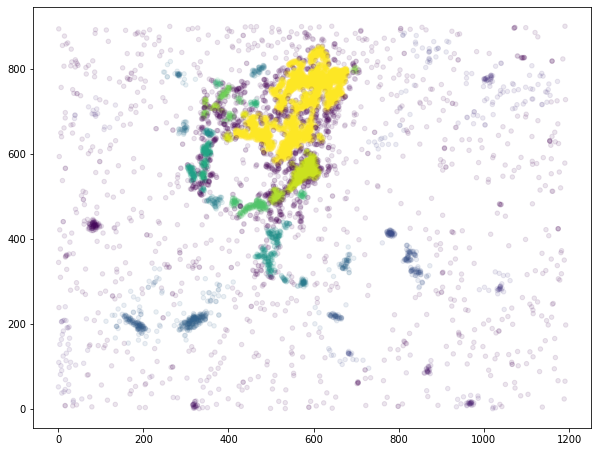

In [8]:
%matplotlib inline

data = np.array([resampleX, resampleY]).T
print(data.shape)

labels = hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(data)

f,ax = plt.subplots(figsize=(10,10))
ax.scatter(data.T[0], data.T[1], c=labels, cmap='viridis', s=20, alpha=0.1)
ax.set_aspect('equal')


# Try looking at this in Firefly

In [8]:
# some_file.py
import sys
sys.path.insert(0, '/Users/ageller/Visualizations/Firefly/static/data')

import pandas as pd
from simpleReader import simpleReader
import requests
from IPython.display import IFrame

## Start the server

In [13]:
%%bash --bg --proc bg_proc
python /Users/ageller/Visualizations/Firefly/FireflyFlaskApp.py

## Show Firefly in an IFrame

In [14]:
url = "http://localhost:5000/combined"
IFrame(url, width=1000, height=700)

## Format the data and send it to Firefly

In [15]:
mx, my, mz = np.mean(resampleX), np.mean(resampleY), np.mean(resampleZ) 
coords = np.array([resampleX - mx, resampleY - my, resampleZ - mz]).T
print(coords.shape)

name = "part1"
outDict = simpleReader(name, coords, [1,1,0,0.1], 10, colorArray=resampleRGBA)
print(outDict['parts'][name]['Coordinates'].shape)

s = pd.Series(outDict).to_json()
requests.post("http://localhost:5000/data_input", json=s)

(12001, 3)
(12001, 3)


<Response [200]>

*To kill the Firefly server.*

In [9]:
# uncomment the next line
! ps aux | grep Firefly | awk '{print $2}' | xargs kill

kill: 46755: No such process


### Try a KDE to get rid of the pixelation?

In [8]:
def density_estimation(x, y, extent, nArr = [None, None]):
    if (nArr[0] != None and nArr[1] != None):
        xgrid, ygrid = np.mgrid[extent[0]:extent[1]:nArr[0], extent[2]:extent[3]:nArr[1]]  
    else:
        xgrid, ygrid = np.mgrid[extent[0]:extent[1], extent[2]:extent[3]]                                                     
    positions = np.vstack([xgrid.ravel(), ygrid.ravel()])                                                       
    values = np.vstack([x, y])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    zgrid = np.reshape(kernel(positions).T, xgrid.shape)
    return xgrid, ygrid, zgrid

#xKDE, yKDE, zKDE = density_estimation(resampleX, resampleY, [0, max(resampleX), 0, max(resampleY)] )

In [9]:
#f,ax = plt.subplots(figsize=(5,10))
#ax.imshow(np.rot90(zKDE), cmap="Greys", extent=[0, nx, 0, ny])